# Assignment 2: Build a CNN for image recognition.

## Due Date:  March 27, 11:59PM

### Name: Amena Akbary


## Introduction:

1. In this assignment, you will build Convolutional Neural Network to classify CIFAR-10 Images.
2. You can directly load dataset from many deep learning packages.
3. You can use any deep learning packages such as pytorch, keras or tensorflow for this assignment.

## Requirements:

1. You need to load cifar 10 data and split the entire training dataset into training and validation.
2. You will implement a CNN model to classify cifar 10 images with provided structure.
3. You need to plot the training and validation accuracy or loss obtained from above step.
4. Then you can use tuned parameters to train using the entire training dataset.
5. You should report the testing accuracy using the model with complete data.
6. You may try to change the structure (e.g, add BN layer or dropout layer,...) and analyze your findings.

## Google Colab

- If you do not have GPU, the training of a CNN can be slow. Google Colab is a good option.

## Batch Normalization (BN)

### Background:

- Batch Normalization is a technique to speed up training and help make the model more stable.
- In simple words, batch normalization is just another network layer that gets inserted between a hidden layer and the next hidden layer. Its job is to take the outputs from the first hidden layer and normalize them before passing them on as the input of the next hidden layer.

- For more detailed information, you may refer to the original paper: https://arxiv.org/pdf/1502.03167.pdf.

### BN Algorithm:

- Input: Values of $x$ over a mini-batch: $\mathbf{B}$ = $\{x_1,..., x_m\};$
- Output: $\{y_i = BN_{\gamma,\beta}(x_i)\}$, $\gamma, \beta$ are learnable parameters

Normalization of the Input:
$$\mu_{\mathbf{B}} = \frac{1}{m}\sum_{i=1}^m x_i$$
$$\sigma_{\mathbf{B}}^2 = \frac{1}{m}\sum_{i=1}^m (x_i - \mu_{\mathbf{B}})^2$$
$$\hat{x_i} = \frac{x_i - \mu_{\mathbf{B}}}{\sqrt{\sigma_{\mathbf{B}}}^2 + \epsilon}$$
Re-scaling and Offsetting:
$$y_i = \gamma \hat{x_i} + \beta = BN_{\gamma,\beta}(x_i)$$


### Advantages of BN:
1. Improves gradient flow through the network.
2. Allows use of saturating nonlinearities and higher learning rates.
3. Makes weights easier to initialize.
4. Act as a form of regularization and may reduce the need for dropout.

### Implementation:

- The batch normalization layer has already been implemented in many packages. You may simply call the function to build the layer. For example: torch.nn.BatchNorm2d() using pytroch package, keras.layers.BatchNormalization() using keras package.
- The location of BN layer: Please make sure ```BatchNormalization``` is between a ```Conv```/```Dense``` layer and an ```activation``` layer.

## 1. Data preparation

### 1.1. Load data


In [1]:
# Load Cifar-10 Data
# This is just an example, you may load dataset from other packages.
import keras
import numpy as np

### If you can not load keras dataset, un-comment these two lines.
#import ssl
#ssl._create_default_https_context = ssl._create_unverified_context

(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

print('shape of x_train: ' + str(x_train.shape))
print('shape of y_train: ' + str(y_train.shape))
print('shape of x_test: ' + str(x_test.shape))
print('shape of y_test: ' + str(y_test.shape))
print('number of classes: ' + str(np.max(y_train) - np.min(y_train) + 1))

170498071/170498071 [==============================] - 13s 0us/step
shape of x_train: (50000, 32, 32, 3)
shape of y_train: (50000, 1)
shape of x_test: (10000, 32, 32, 3)
shape of y_test: (10000, 1)
number of classes: 10


### 1.2. One-hot encode the labels (5 points)

In the input, a label is a scalar in $\{0, 1, \cdots , 9\}$. One-hot encode transform such a scalar to a $10$-dim vector. E.g., a scalar ```y_train[j]=3``` is transformed to the vector ```y_train_vec[j]=[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]```.

1. Implement a function ```to_one_hot``` that transforms an $n\times 1$ array to a $n\times 10$ matrix.

2. Apply the function to ```y_train``` and ```y_test```.

In [2]:
def to_one_hot(y, num_class=10):
  results = np.zeros((len(y), num_class))
  for i, y in enumerate(y):
    results[i, y] = 1
  return results

y_train_vec = to_one_hot(y_train)
y_test_vec = to_one_hot(y_test)

print('Shape of y_train_vec: ' + str(y_train_vec.shape))
print('Shape of y_test_vec: ' + str(y_test_vec.shape))

print(y_train[0])
print(y_train_vec[0])

Shape of y_train_vec: (50000, 10)
Shape of y_test_vec: (10000, 10)
[6]
[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]


#### Remark: the outputs should be
* Shape of y_train_vec: (50000, 10)
* Shape of y_test_vec: (10000, 10)
* [6]
* [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]

### 1.3. Randomly partition the training set to training and validation sets (5 points)

Randomly partition the 50K training samples to 2 sets:
* a training set containing 40K samples: x_tr, y_tr
* a validation set containing 10K samples: x_val, y_val


In [3]:
from sklearn.model_selection import train_test_split

x_tr, x_val, y_tr, y_val = train_test_split(x_train, y_train_vec, test_size=0.2, random_state=42)

print("Training set size:", x_tr.shape[0])
print("Validation set size:", x_val.shape[0])

print('Shape of x_tr: ' + str(x_tr.shape))
print('Shape of y_tr: ' + str(y_tr.shape))
print('Shape of x_val: ' + str(x_val.shape))
print('Shape of y_val: ' + str(y_val.shape))

Training set size: 40000
Validation set size: 10000
Shape of x_tr: (40000, 32, 32, 3)
Shape of y_tr: (40000, 10)
Shape of x_val: (10000, 32, 32, 3)
Shape of y_val: (10000, 10)


## 2. Build a CNN and tune its hyper-parameters (50 points)

- Build a convolutional neural network model using the below structure:

- It should have a structure of: Conv - ReLU - Max Pool - ConV - ReLU - Max Pool - Dense - ReLU - Dense - Softmax

- In the graph 3@32x32 means the dimension of input image, 32@30x30 means it has 32 filters and the dimension now becomes 30x30 after the convolution.
- All convolutional layers (Conv) should have stride = 1 and no padding.
- Max Pooling has a pool size of 2 by 2.




<img src="network.PNG"/>

- You may use the validation data to tune the hyper-parameters (e.g., learning rate, and optimization algorithm)
- Do NOT use test data for hyper-parameter tuning!!!
- Try to achieve a validation accuracy as high as possible.

In [4]:
#build the model
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))

model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(64, (4, 4), activation='relu'))

model.add(MaxPooling2D((2, 2)))

model.add(Flatten())

model.add(Dense(256, activation='relu'))

model.add(Dense(10, activation='softmax'))

# Print the model summary
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 15, 15, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 12, 12, 64)        32832     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 6, 6, 64)          0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 2304)              0         
                                                                 
 dense (Dense)               (None, 256)               5

In [5]:
# Define model optimizer and loss function
from keras import optimizers

model.compile(optimizers.RMSprop(learning_rate =0.0001), loss = 'categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 15, 15, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 12, 12, 64)        32832     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 6, 6, 64)          0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 2304)              0         
                                                                 
 dense (Dense)               (None, 256)               5

In [6]:
# Train the model and store model parameters/loss values
history = model.fit(x_tr, y_tr, batch_size=128, epochs=50, validation_data=(x_val, y_val))

Epoch 1/50
313/313 [==============================] - 6s 8ms/step - loss: 5.2566 - accuracy: 0.2663 - val_loss: 1.9509 - val_accuracy: 0.3734
Epoch 2/50
313/313 [==============================] - 2s 6ms/step - loss: 1.6504 - accuracy: 0.4381 - val_loss: 1.5382 - val_accuracy: 0.4740
Epoch 3/50
313/313 [==============================] - 2s 6ms/step - loss: 1.3437 - accuracy: 0.5336 - val_loss: 1.5156 - val_accuracy: 0.5007
Epoch 4/50
313/313 [==============================] - 2s 7ms/step - loss: 1.1681 - accuracy: 0.5966 - val_loss: 1.3805 - val_accuracy: 0.5337
Epoch 5/50
313/313 [==============================] - 2s 6ms/step - loss: 1.0258 - accuracy: 0.6447 - val_loss: 1.3912 - val_accuracy: 0.5445
Epoch 6/50
313/313 [==============================] - 2s 6ms/step - loss: 0.9117 - accuracy: 0.6861 - val_loss: 1.5069 - val_accuracy: 0.5271
Epoch 7/50
313/313 [==============================] - 2s 6ms/step - loss: 0.8131 - accuracy: 0.7191 - val_loss: 1.3046 - val_accuracy: 0.5758
Epoch 

## 3. Plot the training and validation loss curve versus epochs. (5 points)

Training Accuracy: 99.90%


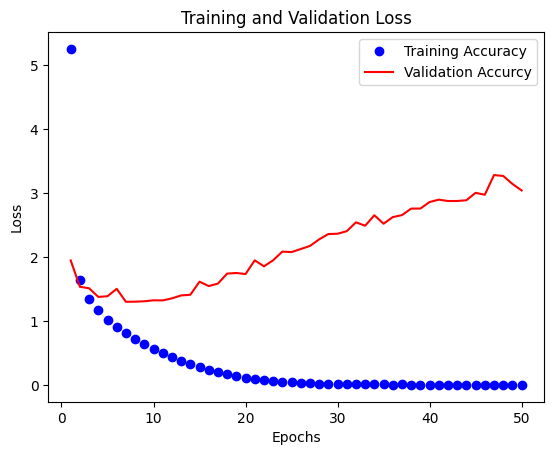

In [7]:
# Plot the loss curve
import matplotlib.pyplot as plt
%matplotlib inline

train_accuracy = history.history['accuracy'][-1]
print(f"Training Accuracy: {train_accuracy * 100:.2f}%")


train_loss = history.history['loss']
valid_loss = history.history['val_loss']

epochs = range(1, len(train_loss) + 1)

plt.plot(epochs, train_loss, 'bo', label = "Training Accuracy")
plt.plot(epochs, valid_loss, 'r', label = 'Validation Accurcy')
plt.title("Training and Validation Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## 4. Train (again) and evaluate the model (5 points)

- To this end, you have found the "best" hyper-parameters.
- Now, fix the hyper-parameters and train the network on the entire training set (all the 50K training samples)
- Evaluate your model on the test set.

### Train the model on the entire training set

Why? Previously, you used 40K samples for training; you wasted 10K samples for the sake of hyper-parameter tuning. Now you already know the hyper-parameters, so why not using all the 50K samples for training?

In [8]:
#<Compile your model again (using the same hyper-parameters you tuned above)>
from keras import optimizers

model.compile(optimizers.RMSprop(learning_rate =0.0001), loss = 'categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 15, 15, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 12, 12, 64)        32832     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 6, 6, 64)          0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 2304)              0         
                                                                 
 dense (Dense)               (None, 256)               5

In [9]:
#<Train your model on the entire training set (50K samples)>
history = model.fit(x_train, y_train_vec, batch_size=128, epochs=50, validation_data=(x_val, y_val))

Epoch 1/50
391/391 [==============================] - 4s 7ms/step - loss: 0.5231 - accuracy: 0.9089 - val_loss: 1.3136 - val_accuracy: 0.6987
Epoch 2/50
391/391 [==============================] - 2s 6ms/step - loss: 0.3222 - accuracy: 0.9296 - val_loss: 0.9241 - val_accuracy: 0.7604
Epoch 3/50
391/391 [==============================] - 3s 7ms/step - loss: 0.2097 - accuracy: 0.9477 - val_loss: 0.5852 - val_accuracy: 0.8362
Epoch 4/50
391/391 [==============================] - 2s 6ms/step - loss: 0.1438 - accuracy: 0.9622 - val_loss: 0.2885 - val_accuracy: 0.9165
Epoch 5/50
391/391 [==============================] - 2s 6ms/step - loss: 0.0957 - accuracy: 0.9734 - val_loss: 0.2237 - val_accuracy: 0.9311
Epoch 6/50
391/391 [==============================] - 2s 6ms/step - loss: 0.0675 - accuracy: 0.9813 - val_loss: 0.1293 - val_accuracy: 0.9629
Epoch 7/50
391/391 [==============================] - 2s 6ms/step - loss: 0.0460 - accuracy: 0.9876 - val_loss: 0.0713 - val_accuracy: 0.9824
Epoch 

## 5. Evaluate the model on the test set (5 points)

Do NOT used the test set until now. Make sure that your model parameters and hyper-parameters are independent of the test set.

313/313 [==============================] - 1s 3ms/step - loss: 3.9162 - accuracy: 0.6485
Testing Accuracy: 64.85%


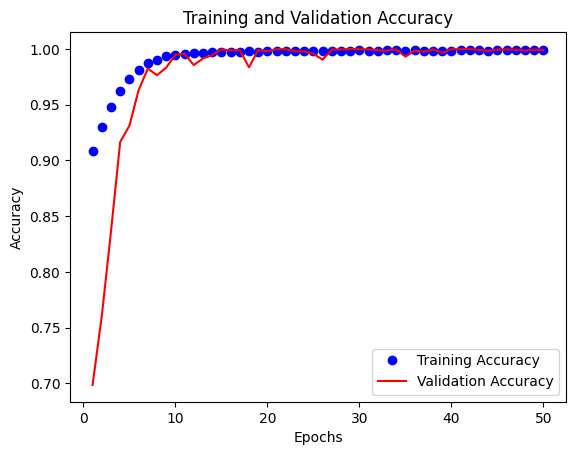

In [10]:
# Evaluate your model performance (testing accuracy) on testing data.
test_loss, test_accuracy = model.evaluate(x_test, y_test_vec)

print(f"Testing Accuracy: {test_accuracy * 100:.2f}%")

train_accuracy = history.history['accuracy']
valid_accuracy = history.history['val_accuracy']
plt.plot(epochs, train_accuracy, 'bo', label="Training Accuracy")
plt.plot(epochs, valid_accuracy, 'r', label="Validation Accuracy")
plt.title("Training and Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

## 6. Building model with new structure (25 points)
- In this section, you can build your model with adding new layers (e.g, BN layer or dropout layer, ...)
- If you want to regularize a ```Conv/Dense layer```, you should place a ```Dropout layer``` before the ```Conv/Dense layer```.
- You can try to compare their loss curve and testing accuracy and analyze your findings.
- You need to try at lease two different structures.

In [11]:
#DROP OUT LAYER
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

#build the model
models = Sequential()

models.add(Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))

models.add(MaxPooling2D((2, 2)))

models.add(Dropout(0.5))

models.add(Conv2D(64, (4, 4), activation='relu'))

models.add(MaxPooling2D((2, 2)))

# models.add(Dropout(0.25))

models.add(Flatten())

models.add(Dense(256, activation='relu'))

# models.add(Dropout(0.5))

models.add(Dense(10, activation='softmax'))

# Print the model summary
models.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 15, 15, 32)        0         
 g2D)                                                            
                                                                 
 dropout (Dropout)           (None, 15, 15, 32)        0         
                                                                 
 conv2d_3 (Conv2D)           (None, 12, 12, 64)        32832     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 6, 6, 64)          0         
 g2D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 2304)             

In [12]:
#compiling
from keras import optimizers

models.compile(optimizers.RMSprop(learning_rate =0.0001), loss = 'categorical_crossentropy', metrics=['accuracy'])

models.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 15, 15, 32)        0         
 g2D)                                                            
                                                                 
 dropout (Dropout)           (None, 15, 15, 32)        0         
                                                                 
 conv2d_3 (Conv2D)           (None, 12, 12, 64)        32832     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 6, 6, 64)          0         
 g2D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 2304)             

In [13]:
#training on partial dataset
history = models.fit(x_tr, y_tr, batch_size=128, epochs=50, validation_data=(x_val, y_val))

Epoch 1/50
313/313 [==============================] - 5s 8ms/step - loss: 9.8139 - accuracy: 0.1493 - val_loss: 2.1220 - val_accuracy: 0.2076
Epoch 2/50
313/313 [==============================] - 2s 7ms/step - loss: 2.0244 - accuracy: 0.2533 - val_loss: 1.8247 - val_accuracy: 0.3308
Epoch 3/50
313/313 [==============================] - 2s 7ms/step - loss: 1.7975 - accuracy: 0.3488 - val_loss: 1.7663 - val_accuracy: 0.3719
Epoch 4/50
313/313 [==============================] - 2s 7ms/step - loss: 1.6541 - accuracy: 0.4014 - val_loss: 1.6879 - val_accuracy: 0.3959
Epoch 5/50
313/313 [==============================] - 2s 6ms/step - loss: 1.5630 - accuracy: 0.4347 - val_loss: 1.6129 - val_accuracy: 0.4218
Epoch 6/50
313/313 [==============================] - 2s 7ms/step - loss: 1.4881 - accuracy: 0.4653 - val_loss: 1.6416 - val_accuracy: 0.4090
Epoch 7/50
313/313 [==============================] - 2s 7ms/step - loss: 1.4340 - accuracy: 0.4854 - val_loss: 1.5125 - val_accuracy: 0.4535
Epoch 

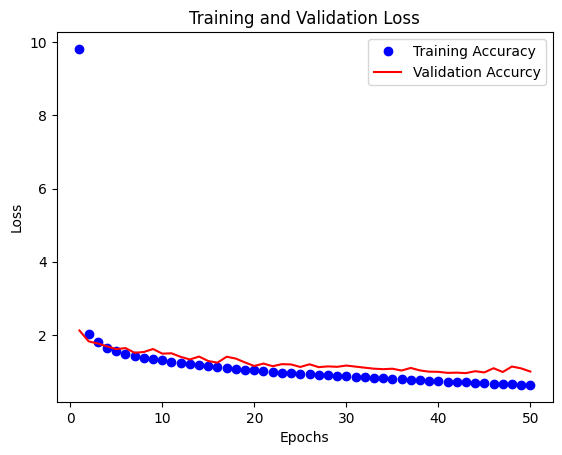

In [14]:
#plotting loss
train_loss = history.history['loss']
valid_loss = history.history['val_loss']

epochs = range(1, len(train_loss) + 1)

plt.plot(epochs, train_loss, 'bo', label = "Training Accuracy")
plt.plot(epochs, valid_loss, 'r', label = 'Validation Accurcy')
plt.title("Training and Validation Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [15]:
#training my model on the complete dataset
history = models.fit(x_train, y_train_vec, batch_size=128, epochs=50, validation_data=(x_val, y_val))

Epoch 1/50
391/391 [==============================] - 3s 8ms/step - loss: 0.7129 - accuracy: 0.7571 - val_loss: 0.9707 - val_accuracy: 0.6710
Epoch 2/50
391/391 [==============================] - 3s 7ms/step - loss: 0.6957 - accuracy: 0.7621 - val_loss: 0.8901 - val_accuracy: 0.6935
Epoch 3/50
391/391 [==============================] - 3s 6ms/step - loss: 0.6774 - accuracy: 0.7675 - val_loss: 0.8312 - val_accuracy: 0.7142
Epoch 4/50
391/391 [==============================] - 3s 7ms/step - loss: 0.6711 - accuracy: 0.7710 - val_loss: 0.8255 - val_accuracy: 0.7143
Epoch 5/50
391/391 [==============================] - 3s 6ms/step - loss: 0.6508 - accuracy: 0.7752 - val_loss: 0.9144 - val_accuracy: 0.6874
Epoch 6/50
391/391 [==============================] - 3s 8ms/step - loss: 0.6443 - accuracy: 0.7804 - val_loss: 0.7734 - val_accuracy: 0.7317
Epoch 7/50
391/391 [==============================] - 3s 7ms/step - loss: 0.6274 - accuracy: 0.7863 - val_loss: 0.8052 - val_accuracy: 0.7211
Epoch 

313/313 [==============================] - 1s 3ms/step - loss: 1.1007 - accuracy: 0.6975
Testing Accuracy: 69.75%


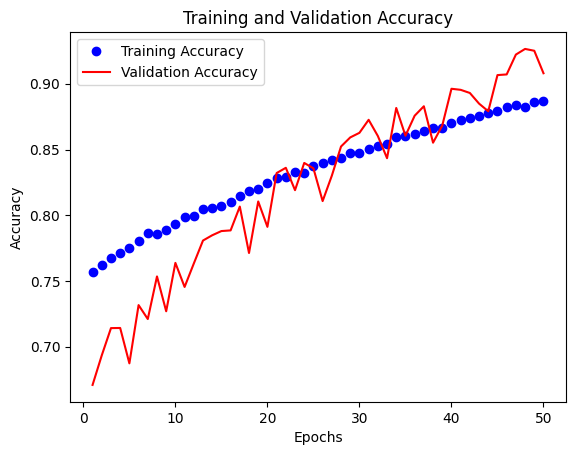

In [16]:
#plotting accuracy
test_loss, test_accuracy = models.evaluate(x_test, y_test_vec)

print(f"Testing Accuracy: {test_accuracy * 100:.2f}%")

train_accuracy = history.history['accuracy']
valid_accuracy = history.history['val_accuracy']
plt.plot(epochs, train_accuracy, 'bo', label="Training Accuracy")
plt.plot(epochs, valid_accuracy, 'r', label="Validation Accuracy")
plt.title("Training and Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [17]:
#BN LAYERER
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization

#build the model
modelss = Sequential()

modelss.add(Conv2D(32, (3, 3), input_shape=(32, 32, 3)))

modelss.add(BatchNormalization())

modelss.add(Activation('relu'))

modelss.add(MaxPooling2D((2, 2)))

modelss.add(Conv2D(64, (4, 4)))

modelss.add(BatchNormalization())

modelss.add(Activation('relu'))

modelss.add(MaxPooling2D((2, 2)))

modelss.add(Flatten())

modelss.add(Dense(256))

modelss.add(BatchNormalization())

modelss.add(Activation('relu'))

modelss.add(Dense(10, activation='softmax'))

# Print the model summary
modelss.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 30, 30, 32)        896       
                                                                 
 batch_normalization (Batch  (None, 30, 30, 32)        128       
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 30, 30, 32)        0         
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 15, 15, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 12, 12, 64)        32832     
                                                                 
 batch_normalization_1 (Bat  (None, 12, 12, 64)       

In [18]:
#compiling
from keras import optimizers

modelss.compile(optimizers.RMSprop(learning_rate =0.0001), loss = 'categorical_crossentropy', metrics=['accuracy'])

modelss.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 30, 30, 32)        896       
                                                                 
 batch_normalization (Batch  (None, 30, 30, 32)        128       
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 30, 30, 32)        0         
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 15, 15, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 12, 12, 64)        32832     
                                                                 
 batch_normalization_1 (Bat  (None, 12, 12, 64)       

In [19]:
#training on partial dataset
history = modelss.fit(x_tr, y_tr, batch_size=128, epochs=50, validation_data=(x_val, y_val))

Epoch 1/50
313/313 [==============================] - 6s 9ms/step - loss: 1.4962 - accuracy: 0.4735 - val_loss: 1.3515 - val_accuracy: 0.5189
Epoch 2/50
313/313 [==============================] - 2s 7ms/step - loss: 1.1129 - accuracy: 0.6155 - val_loss: 1.1499 - val_accuracy: 0.5974
Epoch 3/50
313/313 [==============================] - 2s 7ms/step - loss: 0.9647 - accuracy: 0.6743 - val_loss: 1.0616 - val_accuracy: 0.6303
Epoch 4/50
313/313 [==============================] - 3s 9ms/step - loss: 0.8624 - accuracy: 0.7119 - val_loss: 0.9912 - val_accuracy: 0.6555
Epoch 5/50
313/313 [==============================] - 2s 7ms/step - loss: 0.7874 - accuracy: 0.7397 - val_loss: 0.9656 - val_accuracy: 0.6664
Epoch 6/50
313/313 [==============================] - 2s 7ms/step - loss: 0.7193 - accuracy: 0.7670 - val_loss: 0.9670 - val_accuracy: 0.6647
Epoch 7/50
313/313 [==============================] - 2s 7ms/step - loss: 0.6631 - accuracy: 0.7890 - val_loss: 0.9228 - val_accuracy: 0.6764
Epoch 

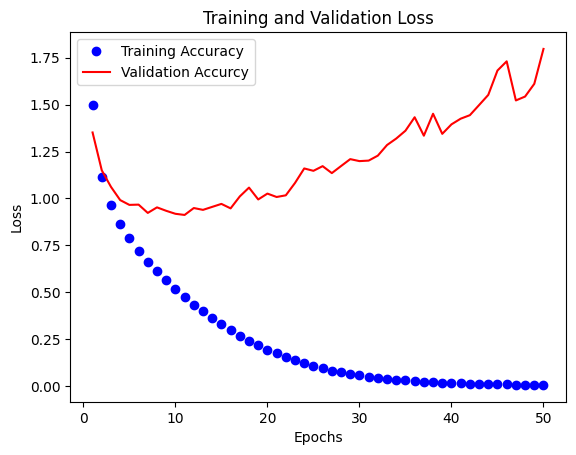

In [20]:
#plotting loss
train_loss = history.history['loss']
valid_loss = history.history['val_loss']

epochs = range(1, len(train_loss) + 1)

plt.plot(epochs, train_loss, 'bo', label = "Training Accuracy")
plt.plot(epochs, valid_loss, 'r', label = 'Validation Accurcy')
plt.title("Training and Validation Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [21]:
#training my model on the complete dataset
history = modelss.fit(x_train, y_train_vec, batch_size=128, epochs=50, validation_data=(x_val, y_val))

Epoch 1/50
391/391 [==============================] - 3s 8ms/step - loss: 0.3141 - accuracy: 0.9325 - val_loss: 0.9319 - val_accuracy: 0.7522
Epoch 2/50
391/391 [==============================] - 3s 8ms/step - loss: 0.1879 - accuracy: 0.9513 - val_loss: 0.4704 - val_accuracy: 0.8572
Epoch 3/50
391/391 [==============================] - 3s 8ms/step - loss: 0.1257 - accuracy: 0.9650 - val_loss: 0.2921 - val_accuracy: 0.9074
Epoch 4/50
391/391 [==============================] - 3s 7ms/step - loss: 0.0884 - accuracy: 0.9770 - val_loss: 0.2353 - val_accuracy: 0.9175
Epoch 5/50
391/391 [==============================] - 3s 7ms/step - loss: 0.0647 - accuracy: 0.9852 - val_loss: 0.1283 - val_accuracy: 0.9655
Epoch 6/50
391/391 [==============================] - 3s 9ms/step - loss: 0.0500 - accuracy: 0.9905 - val_loss: 0.1031 - val_accuracy: 0.9758
Epoch 7/50
391/391 [==============================] - 3s 8ms/step - loss: 0.0399 - accuracy: 0.9937 - val_loss: 0.1235 - val_accuracy: 0.9636
Epoch 

313/313 [==============================] - 1s 3ms/step - loss: 1.8958 - accuracy: 0.6886
Testing Accuracy: 68.86%


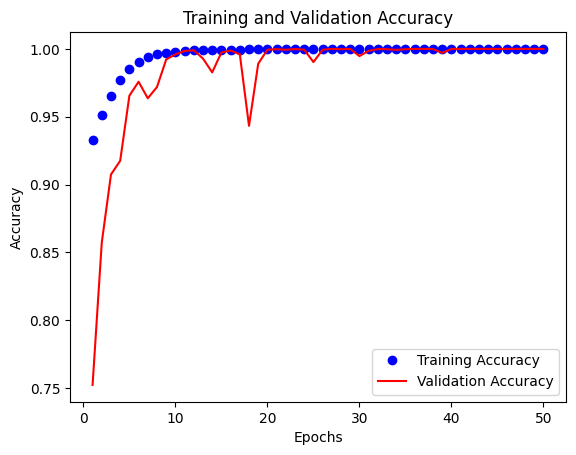

In [22]:
#plotting accuracy
test_loss, test_accuracy = modelss.evaluate(x_test, y_test_vec)

print(f"Testing Accuracy: {test_accuracy * 100:.2f}%")

train_accuracy = history.history['accuracy']
valid_accuracy = history.history['val_accuracy']
plt.plot(epochs, train_accuracy, 'bo', label="Training Accuracy")
plt.plot(epochs, valid_accuracy, 'r', label="Validation Accuracy")
plt.title("Training and Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()